<a href="https://colab.research.google.com/github/parthatom/UnsupervisedClassification/blob/master/Copy_of_Keras_DEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from pathlib import Path
import os
import sys
import pandas as pd
import numpy as np
import sklearn 
import tqdm
from sklearn import model_selection

In [0]:
from sklearn.manifold import TSNE

In [0]:
from tqdm import tqdm

In [6]:
!unzip /content/drive/'My Drive'/Data/MNIST-kaggle/digit-recognizer -d data

Archive:  /content/drive/My Drive/Data/MNIST-kaggle/digit-recognizer.zip
  inflating: data/train.csv          
  inflating: data/test.csv           
  inflating: data/sample_submission.csv  


In [0]:
data_path = Path('/','content', 'data')

In [0]:
df = pd.read_csv(os.path.join(data_path,'train.csv'))

In [0]:
a =  df[ df['label']==0 ].copy()

In [0]:
b = df[df['label'] == 1].copy()

In [0]:
a = pd.concat([a,b], axis = 0)

In [0]:
X=a.drop(columns = ['label']).values

In [0]:
X = np.reshape(X, (-1, 28, 28, 1))
X.shape

(8816, 28, 28, 1)

In [0]:
Y = a['label'].values

In [0]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,Y, test_size = 0.4, shuffle = True, random_state = 42)

In [0]:
x = np.divide(X_train.reshape((X_train.shape[0], -1)), 255.)
x_test = np.divide(X_test.reshape(X_test.shape[0], -1), 255.)

In [0]:
x.shape


(5289, 784)

# [How to do Unsupervised Clustering with Keras](https://www.dlology.com/blog/how-to-do-unsupervised-clustering-with-keras/) | DLology

Read my blog post for details.

In [4]:
from keras.datasets import mnist
import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, 10)]
%matplotlib inline

Using TensorFlow backend.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
class Metrics():
  def __init__(self):
    self.nmi = normalized_mutual_info_score
    self.ari = adjusted_rand_score


  def acc(self, y_true, y_pred):
      """
      Calculate clustering accuracy. Require scikit-learn installed
      # Arguments
          y: true labels, numpy.array with shape `(n_samples,)`
          y_pred: predicted labels, numpy.array with shape `(n_samples,)`
      # Return
          accuracy, in [0,1]
      """
      y_true = y_true.astype(np.int64)
      assert y_pred.size == y_true.size
      D = max(y_pred.max(), y_true.max()) + 1
      w = np.zeros((D, D), dtype=np.int64)
      for i in range(y_pred.size):
          w[y_pred[i], y_true[i]] += 1
      from sklearn.utils.linear_assignment_ import linear_assignment
      ind = linear_assignment(w.max() - w)
      return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [0]:
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
metrics = Metrics()

In [0]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


In [10]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))
x_test = np.divide(x_test, 255.)
x = np.divide(x, 255.)

11493376/11490434 [==============================] - 1s 0us/step


In [11]:
n_clusters = len(np.unique(y))
x.shape

(70000, 784)

## Base line K-Means clustering accuracy

In [0]:
kmeans = KMeans(n_clusters=n_clusters)
y_pred_kmeans = kmeans.fit_predict(x)

In [0]:
metrics.acc(y, y_pred_kmeans)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


0.5323571428571429

## Hyper-params

In [0]:
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256
save_dir = './drive/My Drive/Outputs/MNIST_DEC/results'

In [13]:
autoencoder, encoder = autoencoder(dims, init=init)

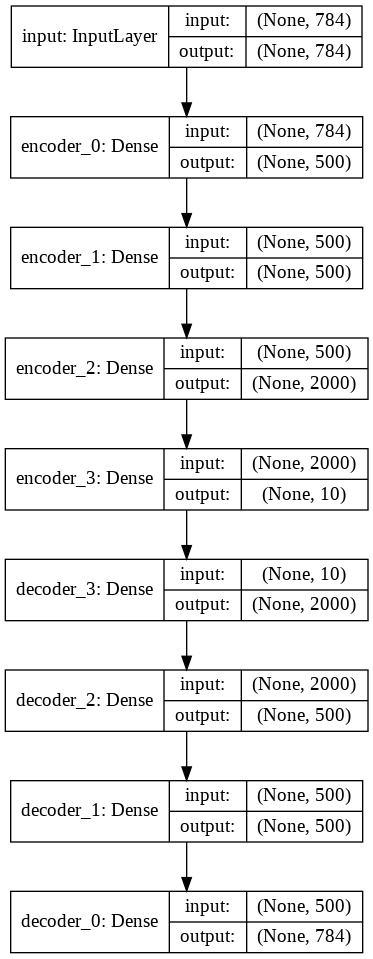

In [0]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png') 

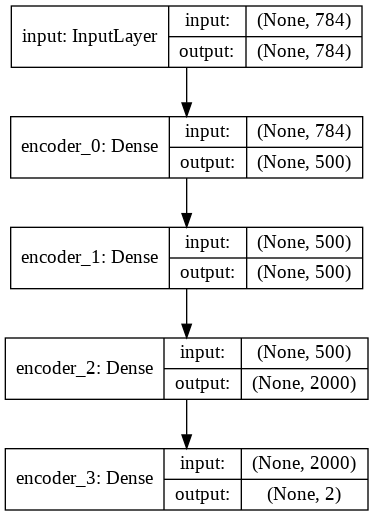

In [0]:
from keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='encoder.png') 

## Pretrain auto-encoder

In [0]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
autoencoder.save_weights(save_dir + '/ae_weights.h5')

Epoch 1/300
70000/70000 [==============================] - 2s 32us/step - loss: 0.0127
Epoch 2/300
70000/70000 [==============================] - 2s 29us/step - loss: 0.0127
Epoch 3/300
70000/70000 [==============================] - 2s 29us/step - loss: 0.0126
Epoch 4/300
70000/70000 [==============================] - 2s 29us/step - loss: 0.0126
Epoch 5/300
70000/70000 [==============================] - 2s 29us/step - loss: 0.0125
Epoch 6/300
70000/70000 [==============================] - 2s 29us/step - loss: 0.0124
Epoch 7/300
70000/70000 [==============================] - 2s 29us/step - loss: 0.0124
Epoch 8/300
70000/70000 [==============================] - 2s 29us/step - loss: 0.0123
Epoch 9/300
70000/70000 [==============================] - 2s 29us/step - loss: 0.0123
Epoch 10/300
70000/70000 [==============================] - 2s 29us/step - loss: 0.0122
Epoch 11/300
70000/70000 [==============================] - 2s 29us/step - loss: 0.0122
Epoch 12/300
70000/70000 [===============

In [0]:
autoencoder.save_weights(save_dir + '/ae_weights.h5')

### Load the pre-trained auto encoder weights

In [14]:
autoencoder.load_weights(save_dir + '/ae_weights.h5')

In [15]:
encodings = encoder.predict(x)
encodings.shape

(70000, 10)

In [21]:
tsne = TSNE(n_components=2).fit_transform(encodings[0::50])
tsne.shape

(1400, 2)

In [22]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

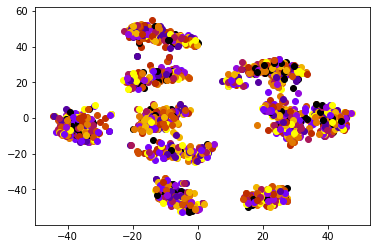

In [0]:
for i in range(len(tsne)):
  plt.scatter(tsne[i][0], tsne[i][1], c=colors[y[i].item()], )
  if(i%10000 == 0):
    plt.savefig(save_dir+'/TSNE_Visualization_for_multiclass_classification.  png')
plt.savefig(save_dir+'/TSNE_Visualization_for_multiclass_classification.png')

In [0]:
decoded_imgs = autoencoder.predict(x_test)

In [0]:
np.reshape(x_test, (10000, -1)).shape

(10000, 784)

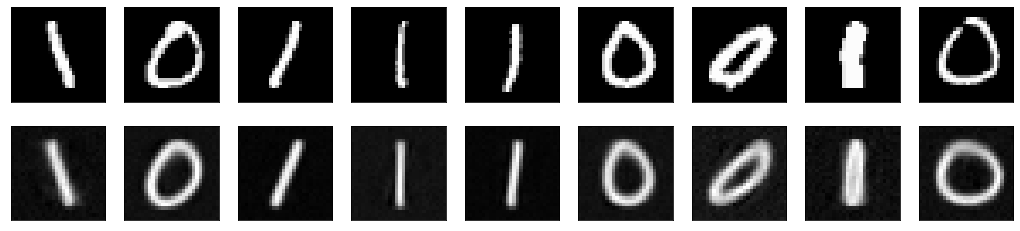

In [0]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Build clustering model

### ClusteringLayer

In [0]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` which represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
clustering_layer = ClusteringLayer(n_clusters = 10, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

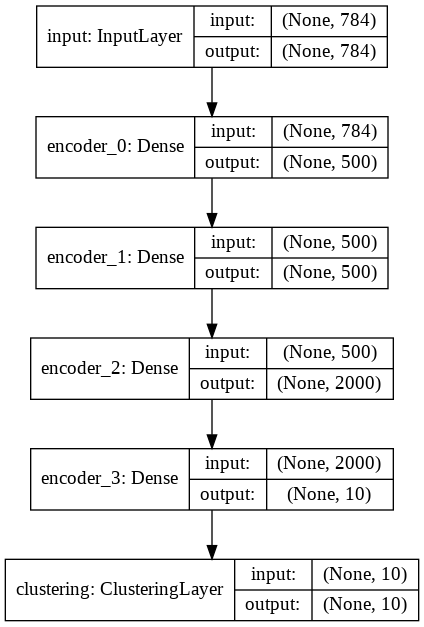

In [33]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 


In [0]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

### Step 1: initialize cluster centers using k-means

In [35]:
colors

[(0.0, 0.0, 0.0, 1.0),
 (0.3313667478318056, 0.00132389503283051, 0.6364742361471414, 1.0),
 (0.4686233489032049, 0.01059116026264408, 0.9818225628535369, 1.0),
 (0.5773502691896257, 0.03703703703703703, 0.8660254037844387, 1.0),
 (0.6656855525711526, 0.0870191404512593, 0.3497265112062616, 1.0),
 (0.746232366691528, 0.17268097488899445, 0.0, 1.0),
 (0.816496580927726, 0.2962962962962962, 0.0, 1.0),
 (0.883398073839164, 0.4752681246277827, 0.0, 1.0),
 (0.943502028843273, 0.7054350438368349, 0.0, 1.0),
 (1.0, 1.0, 0.0, 1.0)]

In [0]:
kmeans = KMeans(n_clusters=10, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [0]:
y_pred_last = np.copy(y_pred)

In [0]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### Step 2: deep clustering
Compute p_i by first raising q_i to the second power and then normalizing by frequency per cluster:

In [0]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [0]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])

In [0]:
tol = 0.001 # tolerance threshold to stop training

### Start training

In [48]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        print(y_pred.shape)
        print(y.shape)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/DEC_model_final.h5')

(70000,)
(70000,)
Iter 0: acc = 0.80051, nmi = 0.79030, ari = 0.73628  ; loss= 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)




(70000,)
(70000,)
Iter 140: acc = 0.80567, nmi = 0.79488, ari = 0.74617  ; loss= 0.04678


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 280: acc = 0.81210, nmi = 0.80485, ari = 0.75629  ; loss= 0.14466


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 420: acc = 0.81676, nmi = 0.81385, ari = 0.76518  ; loss= 0.19719


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 560: acc = 0.81974, nmi = 0.81919, ari = 0.77000  ; loss= 0.20851


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 700: acc = 0.82071, nmi = 0.82151, ari = 0.77216  ; loss= 0.20514


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 840: acc = 0.82214, nmi = 0.82401, ari = 0.77400  ; loss= 0.20042


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 980: acc = 0.82297, nmi = 0.82491, ari = 0.77486  ; loss= 0.19889


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 1120: acc = 0.82329, nmi = 0.82597, ari = 0.77553  ; loss= 0.18577


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 1260: acc = 0.82380, nmi = 0.82571, ari = 0.77544  ; loss= 0.18901


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 1400: acc = 0.82449, nmi = 0.82700, ari = 0.77649  ; loss= 0.18595


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 1540: acc = 0.82500, nmi = 0.82768, ari = 0.77675  ; loss= 0.1779


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 1680: acc = 0.82484, nmi = 0.82772, ari = 0.77681  ; loss= 0.16942


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 1820: acc = 0.82461, nmi = 0.82813, ari = 0.77691  ; loss= 0.17411


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 1960: acc = 0.82490, nmi = 0.82867, ari = 0.77755  ; loss= 0.16097


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 2100: acc = 0.82476, nmi = 0.82907, ari = 0.77789  ; loss= 0.16728


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 2240: acc = 0.82444, nmi = 0.82874, ari = 0.77743  ; loss= 0.16243


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 2380: acc = 0.82444, nmi = 0.82873, ari = 0.77764  ; loss= 0.16139


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 2520: acc = 0.82453, nmi = 0.82927, ari = 0.77777  ; loss= 0.15667


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 2660: acc = 0.82450, nmi = 0.82930, ari = 0.77789  ; loss= 0.16794


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 2800: acc = 0.82446, nmi = 0.82982, ari = 0.77787  ; loss= 0.15575


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 2940: acc = 0.82449, nmi = 0.82968, ari = 0.77798  ; loss= 0.14303


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 3080: acc = 0.82446, nmi = 0.83017, ari = 0.77826  ; loss= 0.1458


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 3220: acc = 0.82440, nmi = 0.82998, ari = 0.77796  ; loss= 0.13599


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 3360: acc = 0.82464, nmi = 0.83027, ari = 0.77839  ; loss= 0.13905


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 3500: acc = 0.82433, nmi = 0.83041, ari = 0.77819  ; loss= 0.13907


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 3640: acc = 0.82454, nmi = 0.83046, ari = 0.77847  ; loss= 0.1355


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 3780: acc = 0.82429, nmi = 0.83072, ari = 0.77842  ; loss= 0.12754


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 3920: acc = 0.82419, nmi = 0.83028, ari = 0.77824  ; loss= 0.13253


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 4060: acc = 0.82419, nmi = 0.83057, ari = 0.77846  ; loss= 0.12919


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 4200: acc = 0.82410, nmi = 0.83029, ari = 0.77848  ; loss= 0.12671


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 4340: acc = 0.82416, nmi = 0.83047, ari = 0.77864  ; loss= 0.12944


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 4480: acc = 0.82440, nmi = 0.83066, ari = 0.77905  ; loss= 0.1239


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 4620: acc = 0.82423, nmi = 0.83029, ari = 0.77846  ; loss= 0.12393


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 4760: acc = 0.82400, nmi = 0.82967, ari = 0.77813  ; loss= 0.12489


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 4900: acc = 0.82393, nmi = 0.82996, ari = 0.77800  ; loss= 0.12317


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 5040: acc = 0.82373, nmi = 0.82926, ari = 0.77764  ; loss= 0.12175


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 5180: acc = 0.82357, nmi = 0.82937, ari = 0.77749  ; loss= 0.11988


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 5320: acc = 0.82370, nmi = 0.82926, ari = 0.77769  ; loss= 0.12433


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 5460: acc = 0.82366, nmi = 0.82967, ari = 0.77773  ; loss= 0.11622


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 5600: acc = 0.82359, nmi = 0.82921, ari = 0.77771  ; loss= 0.1187


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 5740: acc = 0.82376, nmi = 0.82998, ari = 0.77804  ; loss= 0.10738


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 5880: acc = 0.82361, nmi = 0.82958, ari = 0.77783  ; loss= 0.11598


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 6020: acc = 0.82403, nmi = 0.83058, ari = 0.77857  ; loss= 0.11066


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 6160: acc = 0.82383, nmi = 0.83062, ari = 0.77847  ; loss= 0.10896


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 6300: acc = 0.82376, nmi = 0.83027, ari = 0.77822  ; loss= 0.10262


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 6440: acc = 0.82387, nmi = 0.83080, ari = 0.77834  ; loss= 0.10759


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 6580: acc = 0.82373, nmi = 0.83045, ari = 0.77812  ; loss= 0.10366


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 6720: acc = 0.82397, nmi = 0.83085, ari = 0.77838  ; loss= 0.10505


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 6860: acc = 0.82403, nmi = 0.83074, ari = 0.77840  ; loss= 0.10206


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 7000: acc = 0.82399, nmi = 0.83049, ari = 0.77816  ; loss= 0.10876


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 7140: acc = 0.82416, nmi = 0.83055, ari = 0.77827  ; loss= 0.10057


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 7280: acc = 0.82390, nmi = 0.83014, ari = 0.77791  ; loss= 0.10334


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(70000,)
(70000,)
Iter 7420: acc = 0.82404, nmi = 0.83040, ari = 0.77809  ; loss= 0.10099
delta_label  0.0009714285714285714 < tol  0.001
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


### Load the clustering model trained weights

In [0]:
model.load_weights(save_dir + '/DEC_model_final.h5')

ValueError: ignored

In [58]:
encodings = encoder.predict(x[0::25])
encodings.shape

(2800, 10)

In [59]:
tsne = TSNE(n_components = 2).fit_transform(encodings)
tsne.shape

(2800, 2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

''

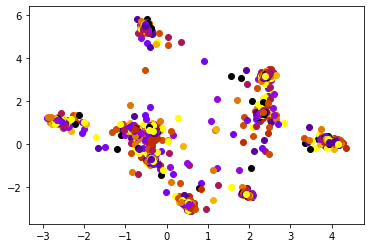

In [60]:
for i in range(len(encodings)):
  plt.scatter(encodings[i][0], encodings[i][1], c=colors[y_train[i].item()])
  if(i%100):
    plt.savefig(save_dir+'/TSNE_Visualization_of_Multiclass_Encoding_With_Clustering_layer_DEC.png')
;    

### Final Evaluation

In [0]:
# Eval.
q = model.predict(x_test, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y_test, y_pred), 5)
    nmi = np.round(metrics.nmi(y_test, y_pred), 5)
    ari = np.round(metrics.ari(y_test, y_pred), 5)
    loss = np.round(loss, 5)
    print('Validation Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Validation Acc = 0.98129, nmi = 0.87781, ari = 0.92653  ; loss= 0.02692


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


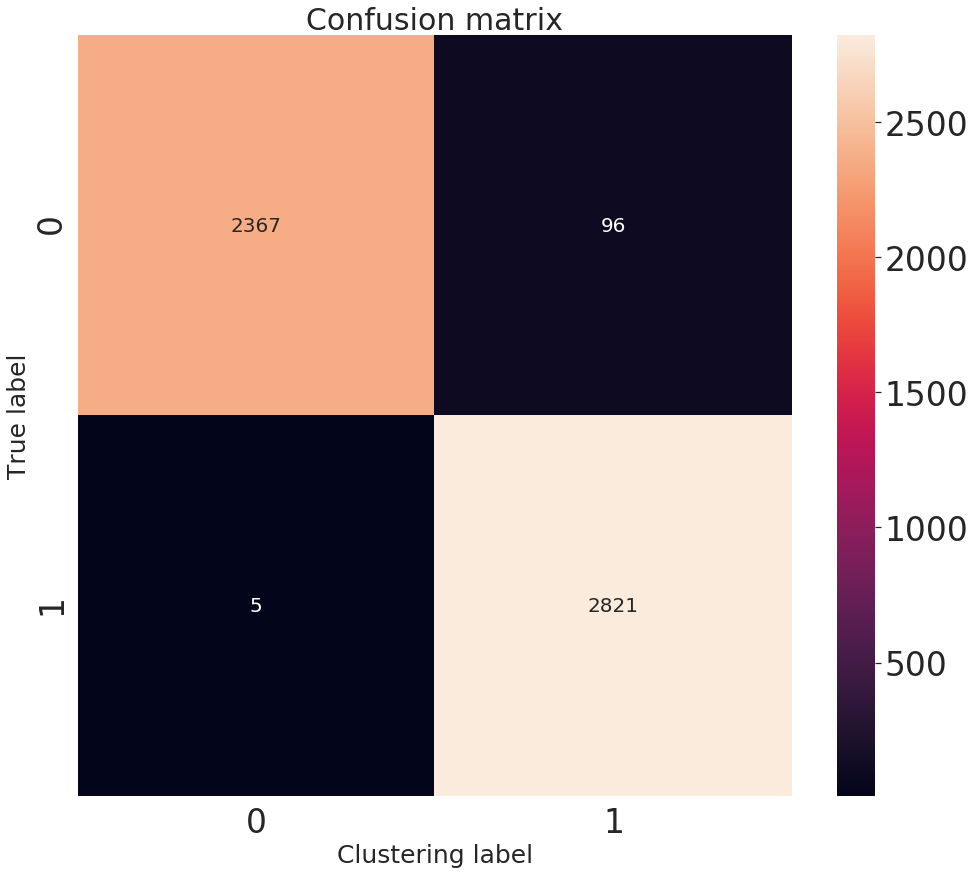

In [0]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y_train, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

### Break down Accuracy metric

linear assignment- [Munkres' Assignment Algorithm](http://csclab.murraystate.edu/~bob.pilgrim/445/munkres.html)

In [0]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = y.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)

sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


0.11533371147664966

In [0]:
w

array([[239, 255, 243, 229, 245, 189, 222, 269, 239, 242],
       [278, 341, 272, 294, 320, 264, 308, 308, 251, 281],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [0]:
ind

array([[0, 6],
       [1, 4],
       [2, 7],
       [3, 9],
       [4, 0],
       [5, 2],
       [6, 3],
       [7, 5],
       [8, 1],
       [9, 8]])

In [0]:
w.argmax(1)

array([6, 4, 7, 5, 0, 2, 3, 5, 1, 8])

## Experimental
Convolutional auto encoder.

In [0]:
from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
import numpy as np

### Convolutional auto encoder option 1
Use [`Conv2DTranspose`](https://keras.io/layers/convolutional/#conv2dtranspose) to reconstruct the image.

In [0]:
def autoencoderConv2D_1(input_shape=(28, 28, 1), filters=[32, 64, 128, 10]):
    input_img = Input(shape=input_shape)
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)

    x = Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2')(x)

    x = Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')(x)

    x = Flatten()(x)
    encoded = Dense(units=filters[3], name='embedding')(x)
    x = Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu')(encoded)

    x = Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2]))(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3')(x)

    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1')(x)
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

### Convolutional auto encoder option 2
Use [`UpSampling2D`](https://keras.io/layers/convolutional/#upsampling2d) to reconstruct the image.

In [0]:
def autoencoderConv2D_2(img_shape=(28, 28, 1)):
    """
    Conv2D auto-encoder model.
    Arguments:
        img_shape: e.g. (28, 28, 1) for MNIST
    return:
        (autoencoder, encoder), Model of autoencoder and model of encoder
    """
    input_img = Input(shape=img_shape)
    # Encoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(input_img)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    shape_before_flattening = K.int_shape(x)
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional
    x = Flatten()(x)
    encoded = Dense(10, activation='relu', name='encoded')(x)

    # Decoder
    x = Dense(np.prod(shape_before_flattening[1:]),
                activation='relu')(encoded)
    # Reshape into an image of the same shape as before our last `Flatten` layer
    x = Reshape(shape_before_flattening[1:])(x)

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


### Pick a convolutional autoencoder
`autoencoderConv2D_1` or `autoencoderConv2D_2`

In [0]:
autoencoder, encoder = autoencoderConv2D_1()

In [0]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 14, 14, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 64)          51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
embedding (Dense)            (None, 10)                11530     
_________________________________________________________________
dense_1 (Dense)              (None, 1152)              12672     
__________

### Load MNIST data for convolutional input

In [0]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape(x.shape + (1,))
x = np.divide(x, 255.)

### Pretrain covolutional autoencoder

In [0]:
pretrain_epochs = 100
batch_size = 256

In [0]:
autoencoder.compile(optimizer='adadelta', loss='mse')

In [0]:
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights(save_dir+'/conv_ae_weights.h5')

Epoch 1/100
70000/70000 [==============================] - 8s 108us/step - loss: 0.0797
Epoch 2/100
70000/70000 [==============================] - 5s 70us/step - loss: 0.0622
Epoch 3/100
70000/70000 [==============================] - 5s 70us/step - loss: 0.0482
Epoch 4/100
70000/70000 [==============================] - 5s 71us/step - loss: 0.0377
Epoch 5/100
70000/70000 [==============================] - 5s 69us/step - loss: 0.0325
Epoch 6/100
70000/70000 [==============================] - 5s 69us/step - loss: 0.0290
Epoch 7/100
70000/70000 [==============================] - 5s 68us/step - loss: 0.0269
Epoch 8/100
70000/70000 [==============================] - 5s 68us/step - loss: 0.0254
Epoch 9/100
70000/70000 [==============================] - 5s 69us/step - loss: 0.0243
Epoch 10/100
70000/70000 [==============================] - 5s 69us/step - loss: 0.0235
Epoch 11/100
70000/70000 [==============================] - 5s 69us/step - loss: 0.0226
Epoch 12/100
70000/70000 [==============

NameError: name 'save_dir' is not defined

In [0]:
autoencoder.load_weights(save_dir+'/conv_ae_weights.h5')

### Build clustering model with convolutional autoencoder

In [0]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
model.compile(optimizer='adam', loss='kld')

### Step 1: initialize cluster centers using k-means

In [0]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [0]:
y_pred_last = np.copy(y_pred)

In [0]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### Step 2: deep clustering

In [0]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])

In [0]:
tol = 0.001 # tolerance threshold to stop training

### Start training

In [0]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/conv_DEC_model_final.h5')

### Load the clustering model trained weights

In [0]:
model.load_weights(save_dir + '/conv_DEC_model_final.h5')

### Final Evaluation

In [0]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.79063, nmi = 0.76515, ari = 0.68468  ; loss= 0


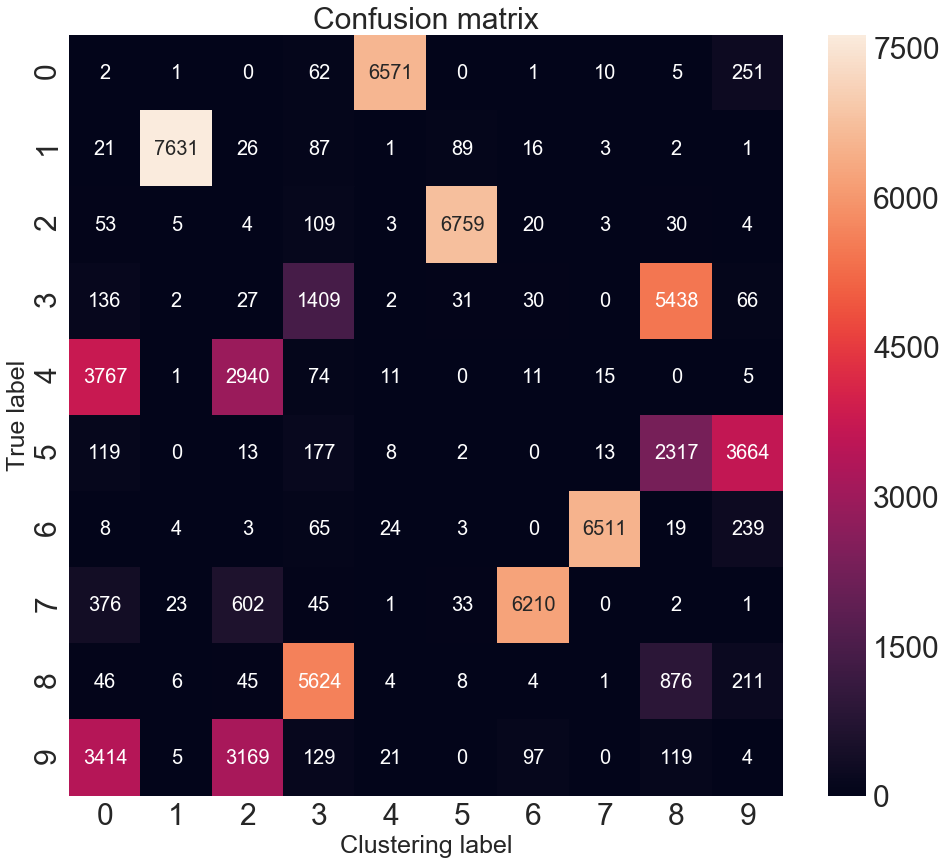

In [0]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

## Model to train clustering and autoencoder at same time(Convolutional)
Multiple outputs model.

In [0]:
autoencoder, encoder = autoencoderConv2D_1()
autoencoder.load_weights(save_dir+'/conv_ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,
                           outputs=[clustering_layer, autoencoder.output])

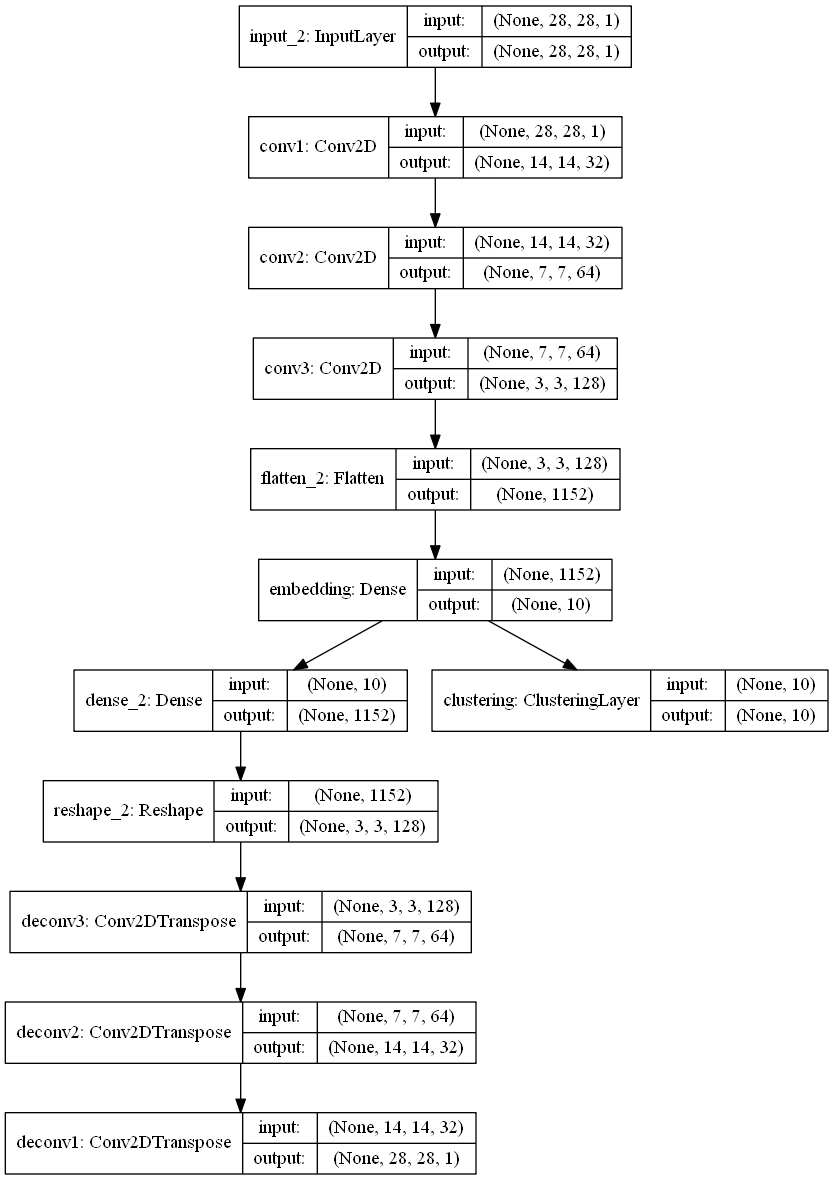

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 


### Initialize cluster centers using k-means

In [0]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [0]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

In [0]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/conv_b_DEC_model_final.h5')

### Load the clustering model trained weights

In [0]:
model.load_weights(save_dir + '/conv_b_DEC_model_final.h5')

### Final Evaluation

In [0]:
# Eval.
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.82233, nmi = 0.80238, ari = 0.73511  ; loss= 0


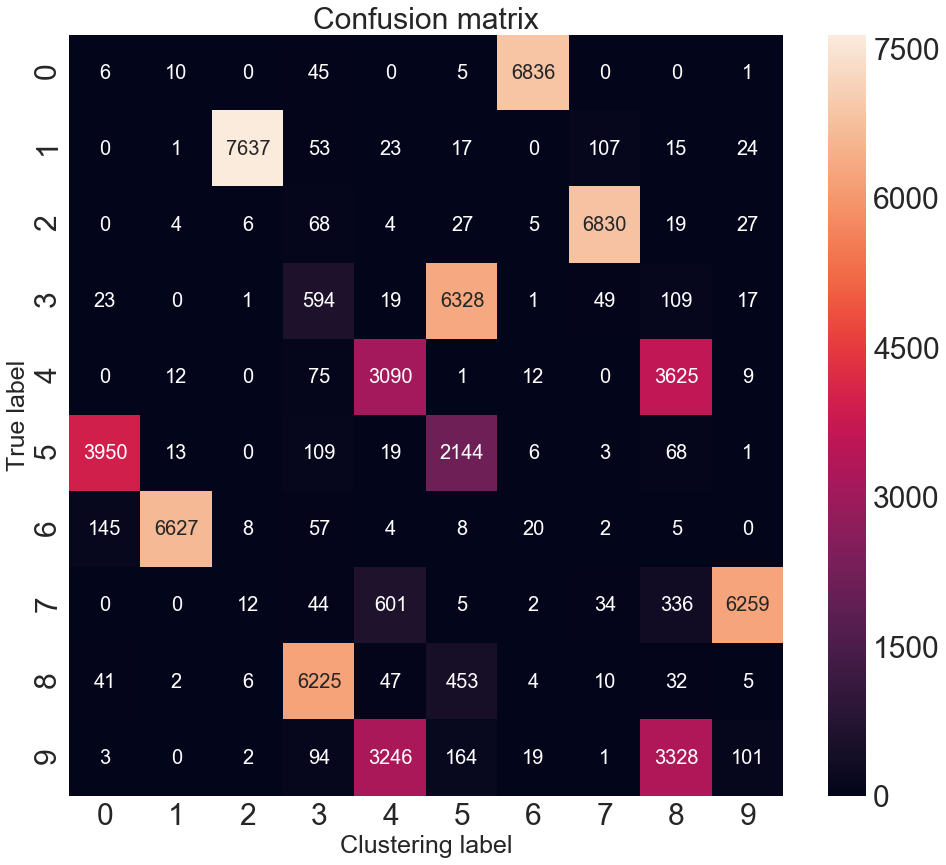

In [0]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

## Model to train clustering and autoencoder at same time(Fully connected)
Multiple outputs model.

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)
n_clusters = len(np.unique(y))
x.shape

(70000, 784)

In [0]:
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256
save_dir = './results'

In [0]:

def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


In [0]:
autoencoder, encoder = autoencoder(dims, init=init)
autoencoder.load_weights(save_dir+'/ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,
            outputs=[clustering_layer, autoencoder.output])

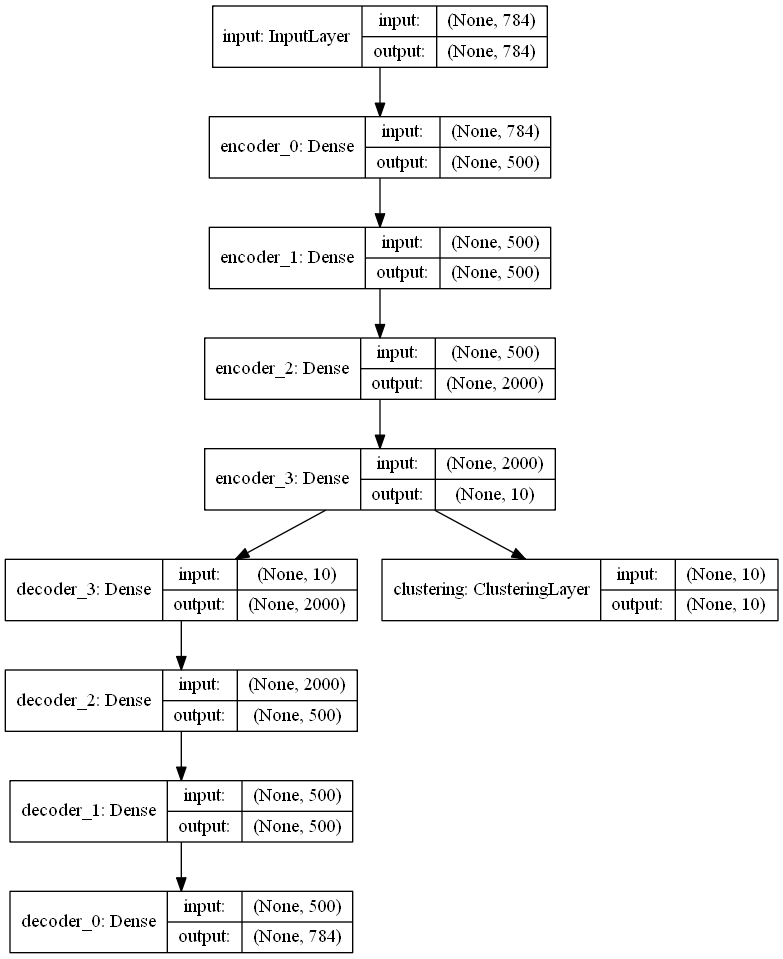

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 

### Initialize cluster centers using k-means

In [0]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [0]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

In [0]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/b_DEC_model_final.h5')

### Load the clustering model trained weights

In [0]:
model.load_weights(save_dir + '/b_DEC_model_final.h5')

### Final Evaluation

In [0]:
# Eval.
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.95587, nmi = 0.89625, ari = 0.90499  ; loss= 0


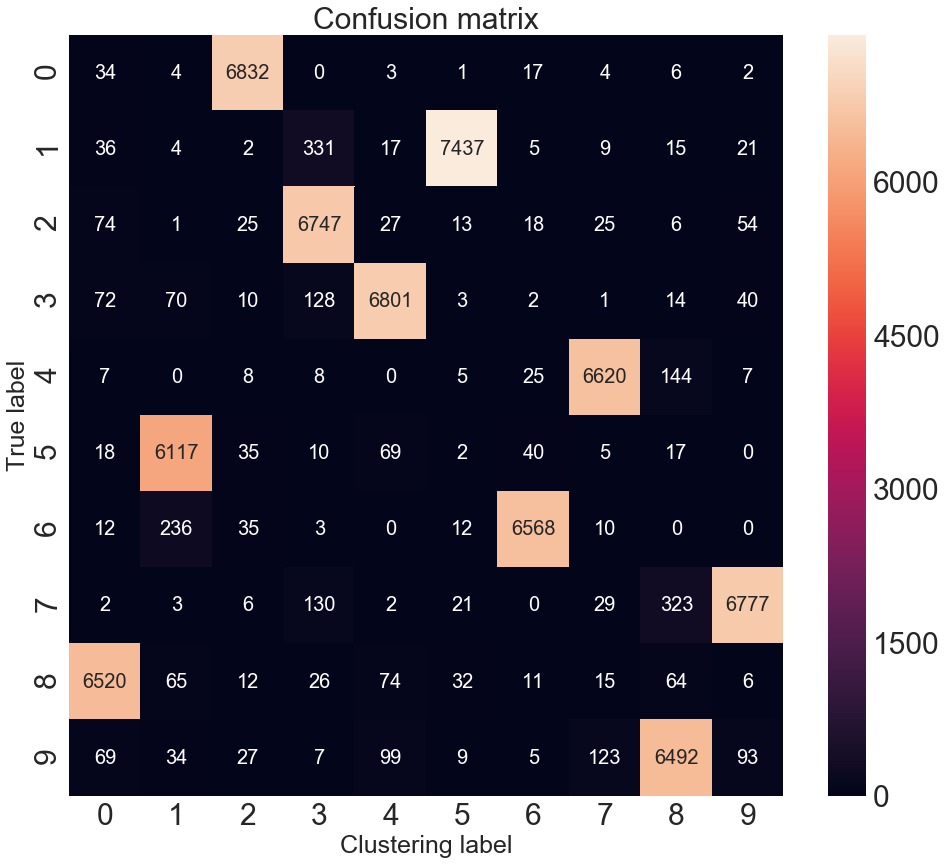

In [0]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()